In [1]:
import requests

import pandas as pd
import numpy

import urllib

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)

from sklearn.linear_model import LinearRegression

In [2]:
url = "https://my4.raceresult.com/RRPublish/data/list.php"

In [3]:
data = None
names = ['Kilian Jornet', 'Simen Holvik' ,'Didrik Hermansen' ,'Jo Inge Norum' ,'Harald Bjerke', 'Sebastian Conrad Håkansson']

for i in range(6):
    params = dict(
        eventid='161360',
        key='180cfe5919da8ef87c1ffaa8c5beddd4',
        listname='Online|Details+laps',
        page='results',
        contest='0',
        r='bib2',
        bib=f'{i+1}'
    )

    param_str = urllib.parse.urlencode(params).replace("%2B", '+')
    r = requests.get(url, params=param_str)
    _data = numpy.array(r.json()['data'])[:, 1:]
    print("Got Data")
    _data = numpy.hstack((_data, i * numpy.ones((_data.shape[0], 1))))
    if data is None:
        print("Setting intial data")
        data = _data
    else:
        print("Appending data {}".format(_data.shape))
        data = numpy.concatenate((data, _data))

Got Data
Setting intial data
Got Data
Appending data (520, 7)
Got Data
Appending data (437, 7)
Got Data
Appending data (548, 7)
Got Data
Appending data (580, 7)
Got Data
Appending data (403, 7)


In [4]:
df = pd.DataFrame(data, columns=[d['Label'] for d in r.json()['list']['Fields']] + ["name"])
df["name"] = df['name'].astype(float).apply(lambda x: names[int(x)])
df['Distance'] = df['Distance'].astype(float)
df['Lap'] = df['Lap'].astype(int)
df['Speed (km/h)'] = df['Speed (km/h)'].astype(float)
df['Total time'] = pd.to_timedelta(df['Total time'].apply(lambda time: time if len(time.split(':')) > 2 else '0:' + time))
df.head()

,Lap,Distance,Lap time,Total time,Pace (min/km),Speed (km/h),name
0,337,134.8,2:06,10:19:56,5:17,11.3,Kilian Jornet
1,336,134.4,2:10,10:17:49,5:27,10.9,Kilian Jornet
2,335,134.0,2:12,10:15:38,5:31,10.8,Kilian Jornet
3,334,133.6,2:09,10:13:25,5:23,11.1,Kilian Jornet
4,333,133.2,2:07,10:11:16,5:19,11.2,Kilian Jornet


In [5]:
print(df['Total time'].max())

0 days 23:59:02


In [6]:
df.groupby('name')['Distance'].max().sort_values(ascending=False)

name
Harald Bjerke                 232.0
Jo Inge Norum                 219.2
Simen Holvik                  208.0
Didrik Hermansen              174.8
Sebastian Conrad Håkansson    161.2
Kilian Jornet                 134.8
Name: Distance, dtype: float64

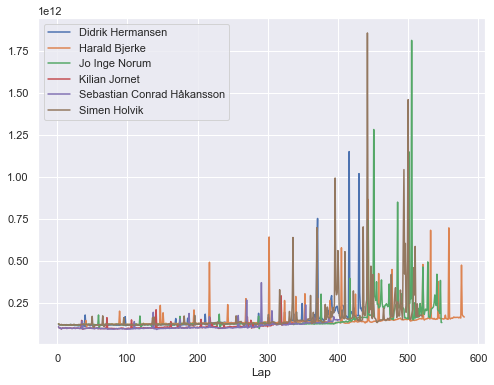

In [7]:
fig, ax = plt.subplots(figsize=(8,6))

for name, dff in df.groupby('name'):
    dff = dff.sort_values('Lap')
    dff['diffs'] = dff['Total time'].diff()
    dff.plot(x='Lap', y='diffs', ax=ax, label=name)
ax

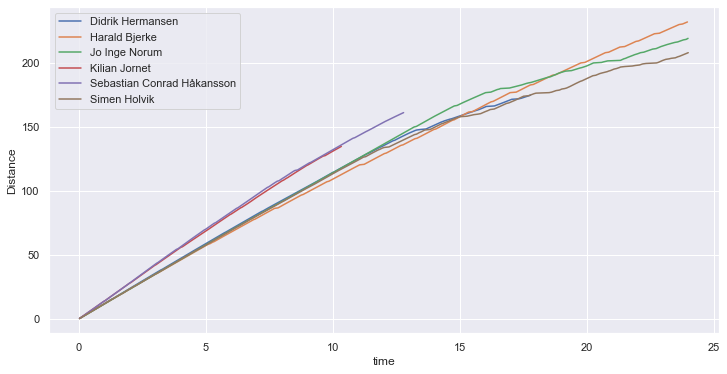

In [8]:
fig, ax = plt.subplots(figsize=(12,6));

for name, dff in df.groupby('name'):
    dff = dff.sort_values('Lap')
    dff['time'] = dff['Total time'].dt.total_seconds() / 3600.
    dff.plot(x='time', y='Distance', ax=ax, label=name)
ax.set_ylabel('Distance');
ax

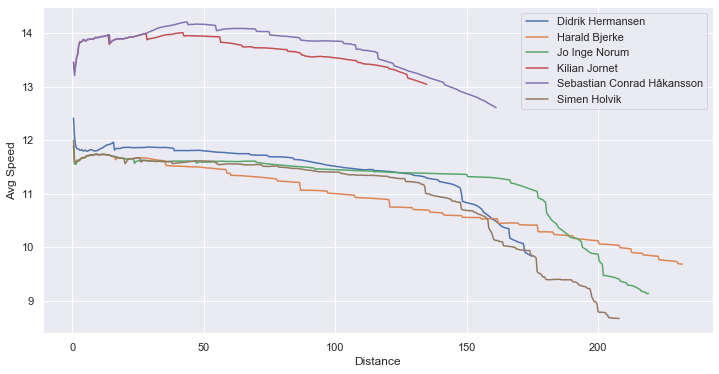

In [9]:
fig, ax = plt.subplots(figsize=(12,6));

for name, dff in df.groupby('name'):
    dff = dff.sort_values('Lap')
    dff['speed'] = 3600 * dff['Distance'] / dff['Total time'].dt.total_seconds()
    dff.plot(y='speed', x='Distance', ax=ax, label=name)
ax.set_ylabel('Avg Speed');
ax

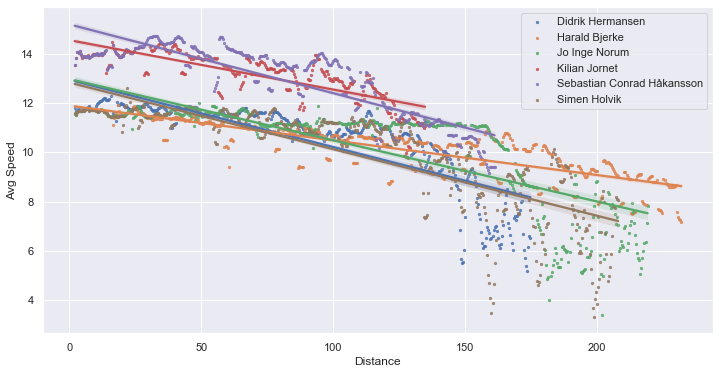

In [150]:
fig, ax = plt.subplots(figsize=(12,6));

equations = []

for name, dff in df.groupby('name'):
#     if 'Har' not in name:
#         continue
    dff = dff.sort_values('Lap')
    lf = LinearRegression()
    lf.fit(dff['Distance'].astype(float).values.reshape(-1, 1),dff['Speed (km/h)'])
    equations.append([lf.intercept_, lf.coef_[0], name])
    dff['rolling_speed'] = dff['Speed (km/h)'].rolling(5).mean()
    sns.regplot(y=dff['rolling_speed'], x=dff['Distance'], ax=ax, scatter_kws={'s':5}, label=name)
ax.set_ylabel('Avg Speed');
ax.legend()

In [135]:
df_regression = pd.DataFrame(equations, columns=['intercept', 'coef', 'name'])
df_regression['coef_100'] = 100 * df_regression['coef']
df_regression['ratio'] = 100 * df_regression['coef_100'] / df_regression['intercept'] 
df_regression

,intercept,coef,name,coef_100,ratio
0,12.919207,-0.027415,Didrik Hermansen,-2.741538,-21.220635
1,11.880357,-0.014078,Harald Bjerke,-1.407809,-11.849891
2,12.920278,-0.024569,Jo Inge Norum,-2.456876,-19.015661
3,14.516940,-0.019955,Kilian Jornet,-1.995544,-13.746314
4,15.148217,-0.027846,Sebastian Conrad Håkansson,-2.784596,-18.382336
5,12.781103,-0.026786,Simen Holvik,-2.678601,-20.957514


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


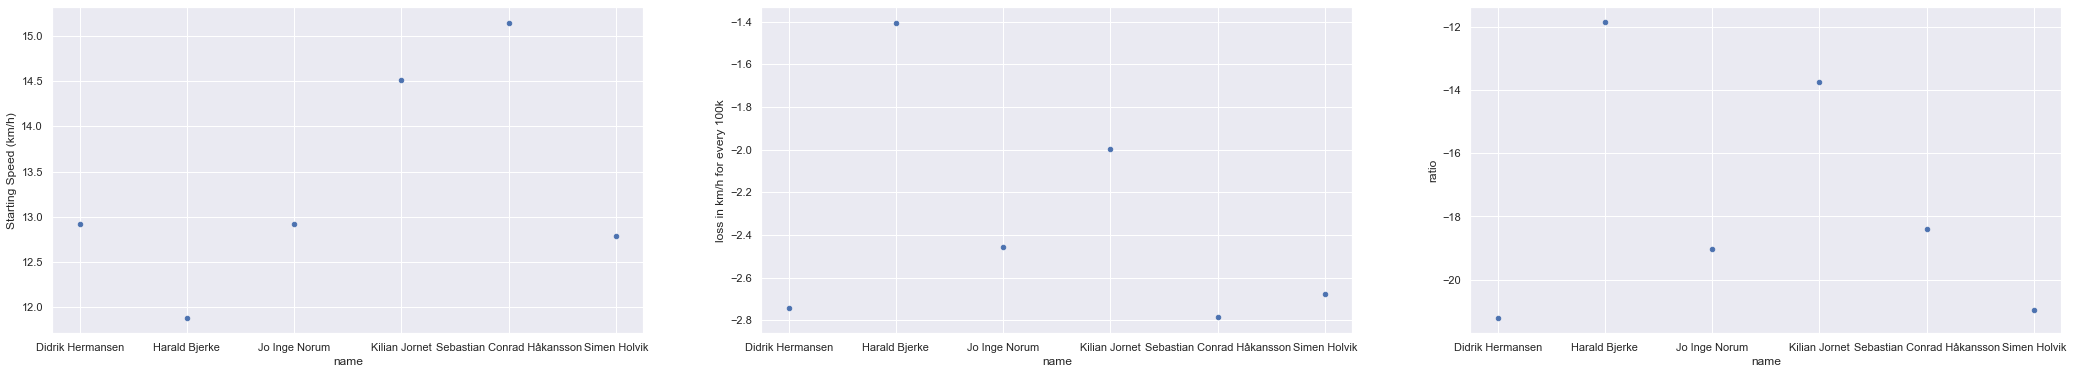

In [152]:
nb_plots = 3
fig, ax = plt.subplots(1, nb_plots, figsize=(nb_plots * 12,6));

df_regression.plot.scatter(x='name', y='intercept', ax=ax[0]);
ax[0].set_ylabel("Starting Speed (km/h)")
df_regression.plot.scatter(x='name', y='coef_100', ax=ax[1]);
ax[1].set_ylabel('loss in km/h for every 100k')
df_regression.plot.scatter(x='name', y='ratio', ax=ax[2]);

/Users/wesleybanfield/miniconda3/envs/Python37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


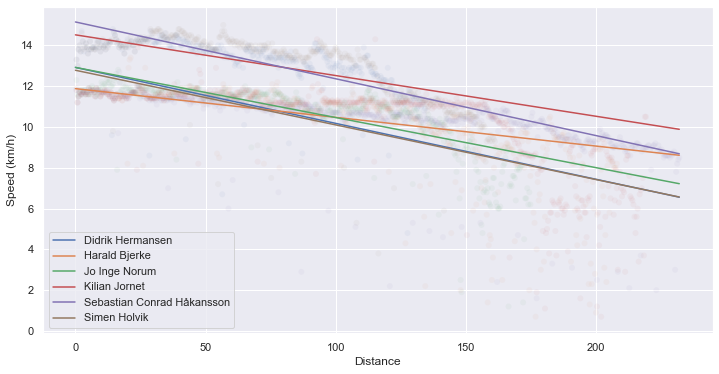

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(12,6));

x = numpy.linspace(0,232,10)
for _index,row in df_regression.iterrows():
    y = row['coef']*x+row['intercept']
    plt.plot(x, y, label=row['name'])
    
sns.scatterplot(df['Distance'], df['Speed (km/h)'], hue=df['name'], alpha=0.05, legend=False)
ax.legend();